<a href="https://colab.research.google.com/github/sangyoon4-ui/Vision/blob/main/Apple_Count_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**GPU 확인**

In [ ]:
import torch, torchvision, platform
print("torch:", torch.__version__, "| torchvision:", torchvision.__version__, "| python:", platform.python_version())
print("CUDA available:", torch.cuda.is_available())


torch: 2.8.0+cu126 | torchvision: 0.23.0+cu126 | python: 3.12.12
CUDA available: True


**필수 패키지**

In [ ]:
!git clone https://github.com/nicolaihaeni/MinneApple.git
%cd /content/MinneApple

# cocoapi(평가에 필요) + 기타
!pip -q install pycocotools six opencv-python scikit-learn


Cloning into 'MinneApple'...
remote: Enumerating objects: 89, done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 89 (from 1)
Receiving objects: 100% (89/89), 2.47 MiB | 4.96 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/MinneApple


**호환성 패치**

In [ ]:
from pathlib import Path

# (A) torch._six 를 six로 대체 + string_classes → string_types
p = Path("/content/MinneApple/utility/coco_eval.py")
s = p.read_text()
s = s.replace("import torch._six as _six", "import six as _six")
s = s.replace("import torch._six",         "import six as _six")
s = s.replace("torch._six",                "_six")
s = s.replace("string_classes",            "string_types")
p.write_text(s)
print("patched:", p)

# (B) train_rcnn.py: 평가 split을 test → val 로 변경
p = Path("/content/MinneApple/train_rcnn.py")
s = p.read_text()
s = s.replace("os.path.join(args.data_path, 'test')", "os.path.join(args.data_path, 'val')")
p.write_text(s)
print("patched:", p)


patched: /content/MinneApple/utility/coco_eval.py
patched: /content/MinneApple/train_rcnn.py


**구글 드라이브 마운트**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/MinneAppleData"
RUNS_DIR = "/content/drive/MyDrive/MinneApple_runs"
!mkdir -p "$DATA_DIR" "$RUNS_DIR"
print("DATA_DIR:", DATA_DIR)
print("RUNS_DIR:", RUNS_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR: /content/drive/MyDrive/MinneAppleData
RUNS_DIR: /content/drive/MyDrive/MinneApple_runs


**Data 저장**

In [ ]:
# 드라이브에 detection.tar.gz가 없으면 다운로드, 있으면 재사용
import os, subprocess, shlex

tar_path = f"{DATA_DIR}/detection.tar.gz"
det_root = f"{DATA_DIR}/detection"

# 4-1) 다운로드(진행률 표시), 이미 있으면 건너뜀
if not os.path.exists(tar_path):
    print("[Downloading detection.tar.gz (~1.7GB) → Google Drive]")
    cmd = f'wget -c "https://conservancy.umn.edu/bitstream/handle/11299/206575/detection.tar.gz" -O "{tar_path}"'
    subprocess.run(shlex.split(cmd), check=True)
else:
    print("[Skip] detection.tar.gz already exists in Drive.")

# 4-2) 압축 해제(한 번만)
if not os.path.exists(f"{det_root}/train/images"):
    print("[Extracting to Drive ...]")
    cmd = f'tar -xzf "{tar_path}" -C "{DATA_DIR}"'
    subprocess.run(shlex.split(cmd), check=True)
else:
    print("[Skip] detection/ already extracted.")

# 4-3) 구조 확인
print("\n[Tree]")
subprocess.run(shlex.split(f'find "{det_root}" -maxdepth 2 -type d | sort'))


[Downloading detection.tar.gz (~1.7GB) → Google Drive]
[Extracting to Drive ...]

[Tree]


CompletedProcess(args=['find', '/content/drive/MyDrive/MinneAppleData/detection', '-maxdepth', '2', '-type', 'd', '|', 'sort'], returncode=1)

**Val 스플릿 생성**

In [ ]:
import os, random, shutil, glob, pathlib, subprocess, shlex

root = f"{DATA_DIR}/detection"
train_img_dir = f"{root}/train/images"
train_msk_dir = f"{root}/train/masks"
val_img_dir   = f"{root}/val/images"
val_msk_dir   = f"{root}/val/masks"

os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_msk_dir, exist_ok=True)

imgs = sorted(glob.glob(os.path.join(train_img_dir, "*.*")))
print("train images:", len(imgs))

# 이미 만들어져 있으면 스킵
if len(glob.glob(os.path.join(val_img_dir, "*.*"))) > 0:
    print("[Skip] val split already exists.")
else:
    random.seed(0)
    pick_n = min(200, len(imgs))  # 필요시 개수 조절
    pick = random.sample(imgs, pick_n)
    moved = 0
    for img_path in pick:
        base = pathlib.Path(img_path).stem
        cand_masks = glob.glob(os.path.join(train_msk_dir, base + ".*"))
        if not cand_masks:
            continue
        msk_path = cand_masks[0]
        shutil.copy2(img_path, os.path.join(val_img_dir, os.path.basename(img_path)))
        shutil.copy2(msk_path, os.path.join(val_msk_dir, os.path.basename(msk_path)))
        moved += 1
    print("val samples created:", moved)

print("\n[Tree after val]")
subprocess.run(shlex.split(f'find "{root}" -maxdepth 2 -type d | sort'))


train images: 670
val samples created: 200

[Tree after val]


CompletedProcess(args=['find', '/content/drive/MyDrive/MinneAppleData/detection', '-maxdepth', '2', '-type', 'd', '|', 'sort'], returncode=1)

**학습 실행**

In [ ]:
import torch, subprocess, datetime, os, glob

DATA_DIR = "/content/drive/MyDrive/MinneAppleData"
RUNS_DIR = "/content/drive/MyDrive/MinneApple_runs"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTDIR = f"{RUNS_DIR}/fasterrcnn_ep10_{stamp}"
os.makedirs(OUTDIR, exist_ok=True)
print("OUTDIR:", OUTDIR)

cmd = [
    "python", "/content/MinneApple/train_rcnn.py",
    "--data_path", f"{DATA_DIR}/detection",
    "--model", "frcnn",
    "--epochs", "1",
    "--device", DEVICE,
    "-b", "2",
    "-j", "2",
    "--output-dir", OUTDIR,
]
print("CMD:", " ".join(cmd))
ret = subprocess.run(cmd)
print("exit code:", ret.returncode)

files = sorted(glob.glob(f"{OUTDIR}/model_*.pth"))
print("ckpts:", len(files), files[:3], "...", files[-3:] if files else [])


Using device: cpu
OUTDIR: /content/drive/MyDrive/MinneApple_runs/fasterrcnn_ep10_20251106_212809
CMD: python /content/MinneApple/train_rcnn.py --data_path /content/drive/MyDrive/MinneAppleData/detection --model frcnn --epochs 1 --device cpu -b 2 -j 2 --output-dir /content/drive/MyDrive/MinneApple_runs/fasterrcnn_ep10_20251106_212809
exit code: 2
ckpts: 0 [] ... []


**예측 JSON 생성**

In [ ]:
import glob, os, subprocess, shlex

RUNS = "/content/drive/MyDrive/MinneApple_runs"
DATA = "/content/drive/MyDrive/MinneAppleData/detection"

print("[runs dir]")
subprocess.run(shlex.split(f'find "{RUNS}" -maxdepth 2 -type f | sort | tail -n 10'))

ckpts = sorted(glob.glob(f"{RUNS}/fasterrcnn/*.pth"))
print("\ncheckpoints found:", len(ckpts))
assert ckpts, "체크포인트(.pth)가 없습니다. 6번 학습이 제대로 끝났는지 확인하세요."
WEIGHTS = ckpts[-1]
print("Using:", WEIGHTS)

print("\n[data splits]")
subprocess.run(shlex.split(f'find "{DATA}" -maxdepth 2 -type d | sort'))


[runs dir]

checkpoints found: 5
Using: /content/drive/MyDrive/MinneApple_runs/fasterrcnn/model_4.pth

[data splits]


CompletedProcess(args=['find', '/content/drive/MyDrive/MinneAppleData/detection', '-maxdepth', '2', '-type', 'd', '|', 'sort'], returncode=1)

In [ ]:
import os, subprocess, shlex

DATA = "/content/drive/MyDrive/MinneAppleData/detection"
if not os.path.exists(f"{DATA}/test/images"):
    print("[create test -> link to val/images]")
    os.makedirs(f"{DATA}/test", exist_ok=True)
    # 디렉터리 심볼릭 링크 (이미 있으면 건너뜀)
    if not os.path.exists(f"{DATA}/test/images"):
        # test/images -> ../val/images (링크)
        os.symlink("../val/images", f"{DATA}/test/images", target_is_directory=True)

print("\n[data splits after fix]")
subprocess.run(shlex.split(f'find "{DATA}" -maxdepth 2 -type d | sort'))



[data splits after fix]


CompletedProcess(args=['find', '/content/drive/MyDrive/MinneAppleData/detection', '-maxdepth', '2', '-type', 'd', '|', 'sort'], returncode=1)

**python JSON 생성**

In [ ]:
import os, glob, json, torch, torchvision
import numpy as np, cv2
from pathlib import Path
from tqdm import tqdm
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

DATA_DIR = "/content/drive/MyDrive/MinneAppleData/detection"
RUNS_DIR = "/content/drive/MyDrive/MinneApple_runs"
WEIGHTS  = "/content/drive/MyDrive/MinneApple_runs/fasterrcnn/model_4.pth"
OUT_JSON = f"{RUNS_DIR}/preds_frcnn.json"

os.makedirs(RUNS_DIR, exist_ok=True)

# 1) 이미지 목록: test가 없으면 val 사용
img_root = Path(DATA_DIR) / "test" / "images"
if not img_root.exists():
    img_root = Path(DATA_DIR) / "val" / "images"
assert img_root.exists(), f"No images under {img_root}"
img_paths = sorted([p for p in img_root.glob("*.*") if p.is_file()])
print("num images:", len(img_paths))

# 2) 모델 생성 (Faster R-CNN, 2 classes)
num_classes = 2
try:
    from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
except Exception:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3) 체크포인트 로드(두 케이스 모두 지원)
ckpt = torch.load(WEIGHTS, map_location=device)
state = ckpt['model'] if isinstance(ckpt, dict) and 'model' in ckpt else ckpt
missing, unexpected = model.load_state_dict(state, strict=False)
print("load_state missing:", missing)
print("load_state unexpected:", unexpected)

model.eval()

def to_tensor(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    return torch.from_numpy(rgb).permute(2,0,1)

results = []
with torch.no_grad():
    for p in tqdm(img_paths):
        img = cv2.imread(str(p), cv2.IMREAD_COLOR)
        if img is None:
            continue
        out = model([to_tensor(img).to(device)])[0]
        boxes  = out.get('boxes',  torch.empty(0,4, device=device)).detach().cpu().numpy()
        scores = out.get('scores', torch.empty(0,  device=device)).detach().cpu().numpy()
        labels = out.get('labels', torch.empty(0,  device=device)).detach().cpu().numpy()
        for b, s, l in zip(boxes, scores, labels):
            x1,y1,x2,y2 = map(float, b.tolist())
            results.append({
                "image_id": p.name,
                "bbox": [x1,y1,x2,y2],
                "score": float(s),
                "label": int(l),
            })

with open(OUT_JSON, "w") as f:
    json.dump(results, f)
print("saved:", OUT_JSON, "records:", len(results))


num images: 331
load_state missing: []
load_state unexpected: []


100%|██████████| 331/331 [00:58<00:00,  5.63it/s]


saved: /content/drive/MyDrive/MinneApple_runs/preds_frcnn.json records: 27182


**생성 확인**

In [ ]:
import os, json
pred_path = "/content/drive/MyDrive/MinneApple_runs/preds_frcnn.json"
print("exists:", os.path.exists(pred_path))
if os.path.exists(pred_path):
    data = json.load(open(pred_path))
    print("first 2:", data[:2])


exists: True
first 2: [{'image_id': 'dataset1_back_1.png', 'bbox': [285.5922546386719, 471.92022705078125, 320.44317626953125, 510.65020751953125], 'score': 0.997318685054779, 'label': 1}, {'image_id': 'dataset1_back_1.png', 'bbox': [636.3826904296875, 738.9852905273438, 678.524169921875, 772.9627075195312], 'score': 0.9945912957191467, 'label': 1}]


**사과 개수**

In [ ]:
import json, collections

preds = json.load(open("/content/drive/MyDrive/MinneApple_runs/preds_frcnn.json"))
counts = collections.Counter()

TH = 0.5  # 임계값
for det in preds:
    if det["score"] >= TH and det["label"] == 1:  # apple만
        counts[det["image_id"]] += 1

total_apples = sum(counts.values())
print("이미지별 개수 예:", list(counts.items())[:5])
print("총 사과 수:", total_apples)


이미지별 개수 예: [('dataset1_back_1.png', 33), ('dataset1_back_1021.png', 53), ('dataset1_back_1051.png', 39), ('dataset1_back_1081.png', 33), ('dataset1_back_1111.png', 40)]
총 사과 수: 13219


**사과 이미지 테스트**

사과 개수: 19


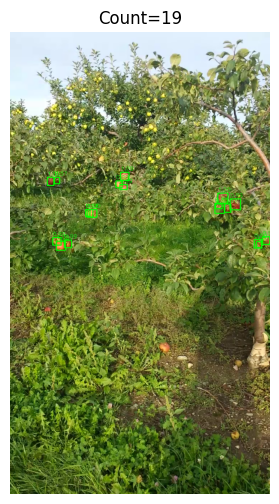

In [ ]:
import torch, torchvision, cv2, numpy as np, glob, os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

WEIGHTS  = "/content/drive/MyDrive/MinneApple_runs/fasterrcnn_ep10/model_8.pth"
IMG_PATH = "/content/drive/MyDrive/MinneAppleData/detection/val/images/20150919_174730_image151.png"  # 단일 이미지 예시

# 1) 모델 만들기 (num_classes=2: background+apple)
num_classes = 2
try:
    from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
except Exception:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)

# 2) 가중치 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(WEIGHTS, map_location=device)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=False)
model.to(device).eval()

# 3) 단일 이미지 추론 + 카운트
img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
x = torch.from_numpy(img_rgb).permute(2,0,1).to(device)

with torch.no_grad():
    out = model([x])[0]

boxes  = out["boxes"].detach().cpu().numpy()
scores = out["scores"].detach().cpu().numpy()
labels = out["labels"].detach().cpu().numpy()

TH = 0.5   # 임계값
APPLE = 1  # apple class id
keep = (labels == APPLE) & (scores >= TH)
boxes, scores = boxes[keep], scores[keep]

print("사과 개수:", len(boxes))

# 시각화(선택)
vis = img_bgr.copy()
for (x1,y1,x2,y2), s in zip(boxes, scores):
    cv2.rectangle(vis, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
    cv2.putText(vis, f"{s:.2f}", (int(x1), int(y1)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title(f"Count={len(boxes)}"); plt.show()


사과 개수: 17


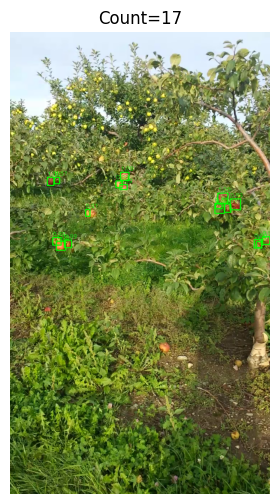

In [ ]:
import torch, torchvision, cv2, numpy as np, glob, os
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

WEIGHTS  = "/content/drive/MyDrive/MinneApple_runs/fasterrcnn_ep10/model_8.pth"
IMG_PATH = "/content/drive/MyDrive/MinneAppleData/detection/val/images/20150919_174730_image151.png"  # 단일 이미지 예시

# 1) 모델 만들기 (num_classes=2: background+apple)
num_classes = 2
try:
    from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
    weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
except Exception:
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)

# 2) 가중치 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(WEIGHTS, map_location=device)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=False)
model.to(device).eval()

# 3) 단일 이미지 추론 + 카운트
img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
x = torch.from_numpy(img_rgb).permute(2,0,1).to(device)

with torch.no_grad():
    out = model([x])[0]

boxes  = out["boxes"].detach().cpu().numpy()
scores = out["scores"].detach().cpu().numpy()
labels = out["labels"].detach().cpu().numpy()

# 0) 1차 필터: 라벨/스코어
TH = 0.5
APPLE = 1
keep = (labels == APPLE) & (scores >= TH)
boxes, scores = boxes[keep], scores[keep]

# 1) NMS로 중복 정리
if len(boxes):
    i = nms(torch.tensor(boxes, dtype=torch.float32),
            torch.tensor(scores, dtype=torch.float32),
            iou_threshold=0.5).numpy()
    boxes, scores = boxes[i], scores[i]

# 2) 크기/종횡비 필터
h, w = img_bgr.shape[:2]
min_area = 12*12     # 너무 작은 박스 제거 (픽셀^2)
max_area = 0.5*h*w   # 터무니없이 큰 박스 제거
ratio_min, ratio_max = 0.5, 2.0  # 가로/세로 비 비정상 제거
_keep = []
for (x1,y1,x2,y2), s in zip(boxes, scores):
    bw, bh = (x2-x1), (y2-y1)
    area = bw*bh
    ratio = bw / (bh+1e-6)
    if area < min_area or area > max_area: continue
    if not (ratio_min <= ratio <= ratio_max): continue
    _keep.append(True)
_boxes = boxes[_keep]; _scores = scores[_keep]

# 3) HSV 색/채도 검사로 오탐 제거 (빨간/녹색 계열 예시)
def is_apple_like(bgr_roi):
    hsv = cv2.cvtColor(bgr_roi, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    # 채도 충분?
    sat_mask = (S >= 60)
    # 빨강: H in [0,10] or [170,180], 녹색: H in [35,85]
    red1 = (H <= 10); red2 = (H >= 170)
    green = (H >= 35) & (H <= 85)
    color_mask = (red1 | red2 | green)
    m = (sat_mask & color_mask).mean()
    return m >= 0.05  # 박스 영역 중 5% 이상이 '사과스러운' 픽셀이면 통과

final_boxes, final_scores = [], []
for (x1,y1,x2,y2), s in zip(_boxes, _scores):
    x1i,y1i,x2i,y2i = map(int, [x1,y1,x2,y2])
    x1i = max(0, x1i); y1i = max(0, y1i)
    x2i = min(w-1, x2i); y2i = min(h-1, y2i)
    roi = img_bgr[y1i:y2i, x1i:x2i]
    if roi.size == 0:
        continue
    if is_apple_like(roi):
        final_boxes.append([x1,y1,x2,y2])
        final_scores.append(s)

final_boxes = np.array(final_boxes)
final_scores = np.array(final_scores)
print("사과 개수:", len(final_boxes))

# 시각화
vis = img_bgr.copy()
for (x1,y1,x2,y2), s in zip(final_boxes, final_scores):
    cv2.rectangle(vis, (int(x1),int(y1)), (int(x2),int(y2)), (0,255,0), 2)
    cv2.putText(vis, f"{s:.2f}", (int(x1), int(y1)-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.title(f"Count={len(final_boxes)}"); plt.show()


추가적으로 할 수 있는 것
- 기존 R-CNN -> Mask R-CNN (Regions with Convolutional Neural Networks features) / 원형도 추가
- anchors 튜닝 (정사각형) / RPN anker aspect ratio
- 색상 단서까지 입력으로 주기 (HSV/LAB) / 기존 RGB에서 HSV/LAB도 활용해보기
- 한번 학습 후 오답으로 확인된 내용들을 사과 아님 혹은 사과로 분류하고 다시 학습 시키기

